<a href="https://colab.research.google.com/github/rpasquini/urban-econometrics/blob/master/5_Modelos_de_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas
import geopandas as gpd
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

     |████████████████████████████████| 972kB 9.4MB/s 
     |████████████████████████████████| 10.9MB 1.4MB/s 
     |████████████████████████████████| 14.7MB 302kB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Extracto de Datos de Goytia, Heikkila, Pasquini (2020)

In [2]:
datosghp=pd.read_csv('https://raw.githubusercontent.com/rpasquini/urban-econometrics/master/data/formal%20premia%20data%20extract.csv')

In [5]:
datosghp

,hora_c,hora_f,bformal,dconurb1,dconurb2,dconurb3,dmore2000,dprop_soloviv,dprop_ocupant,dinquilinos,npersonashogar,dedu_secincomp,dedu_seccomp,dedu_ter_o_mas,ddondevivia2,ddondevivia3,ddondevivia4,ddondevivia5,ddondevivia6,ddondevivia7,dmigrantefuerabarrio,antigenvivienda,nambientes,m2,dconexionagua1,dconexionagua2,dconexionagua3,dpagaelagua,dcloaca,delectricidad_med,dconexiongas,alquiler2,ingresohogar2
0,14.30,14.55,0,0,0,0,1,1,0,0,4,0,0,0,0,0,0,0,0,1,1,4.0,2,2,0,0,1,0.0,1,1,0,12000.0,16500.0
1,13.30,13.55,0,0,0,0,1,0,0,1,4,1,0,0,0,0,0,0,0,1,1,12.0,3,2,0,0,1,0.0,1,1,0,2000.0,12000.0
2,14.25,14.50,0,0,0,0,1,1,0,0,4,1,0,0,0,0,0,0,0,1,1,6.0,4,2,0,0,1,0.0,0,0,0,3000.0,15000.0
3,11.05,11.30,0,0,0,0,1,1,0,0,4,0,1,0,0,0,0,0,0,1,1,10.0,3,2,0,0,1,NaN,0,0,0,6000.0,8000.0
4,9.35,10.00,0,0,0,0,1,1,0,0,8,0,0,0,1,0,0,0,0,0,0,32.0,3,1,0,0,1,0.0,0,0,0,NaN,6800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,10.10,10.50,1,0,0,1,0,0,0,0,5,0,0,1,0,0,0,0,0,0,0,NaN,2,1,0,1,0,0.0,0,1,0,7000.0,25000.0
546,11.40,12.10,1,0,0,1,0,0,0,1,2,0,0,0,0,0,1,0,0,0,1,10.0,2,1,0,1,0,0.0,0,1,1,5000.0,10000.0
547,12.10,12.35,1,0,0,1,0,0,0,0,3,0,1,0,0,0,0,1,0,0,1,26.0,4,2,0,1,0,0.0,0,1,1,5000.0,10000.0
548,11.00,11.30,1,0,0,1,0,0,0,0,3,0,0,1,1,0,0,0,0,0,0,4.0,4,2,0,1,0,0.0,0,1,1,NaN,14000.0


# Estimación de un Modelo de Elección de "Ubicación Residencial" adaptado a una situación de vivir en la formalidad vs. la informalidad. 

Modelo Propuesto:

$P(F=1)_i=\frac{1}{1+e^{-Z_i}}$ \
donde 

$Z_i=\beta_0+\beta_1IngresoHogar_i+\beta_1TamañoHogar_i+\beta_2DSecundarioCompleto_i+\beta_2DTerciarioCompleto_i+\epsilon_i$

In [24]:
def logit(lista, data):
  """ 
  Funcion que realiza la regresion Logit
  La primera variable de la lista es la dependiente, el resto son las explicativas
  data es la base de datos
  """
  datos=data[lista]
  # el metodo dropna() me permite eliminar las filas que tienen algun valor missing
  datos=datos.dropna()
  Y=datos[lista[0]]
  X=datos[lista[1:]]
  X=sm.add_constant(X)
  modelo=sm.Logit(Y,X)
  modeloajustado=modelo.fit()
  print(modeloajustado.summary())
  return modeloajustado

In [33]:
modeloajustado=logit(['bformal', 'ingresohogar2', 'npersonashogar','dedu_seccomp',	'dedu_ter_o_mas'], datosghp)

Optimization terminated successfully.
         Current function value: 0.665327
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                bformal   No. Observations:                  501
Model:                          Logit   Df Residuals:                      496
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Jul 2020   Pseudo R-squ.:                 0.03451
Time:                        18:53:43   Log-Likelihood:                -333.33
converged:                       True   LL-Null:                       -345.24
Covariance Type:            nonrobust   LLR p-value:                 8.645e-05
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.8477      0.267     -3.176      0.001      -1.371      -0.324
ingresohogar2   3

¿Cuál es la probabilidad de que una familia de que una familia con cuatro integrantes, ingreso del hogar de $14000, y jefe con secundario incompleto viva en la formalidad? \
A mano:


In [38]:
import numpy as np

z0=-0.8477+0.00003727*14000-0.0141*4+0*0.6655+0*0.67
f0=1/(1+np.exp(-z0))
f0

0.4055674633633202

Usando el metodo predict


In [46]:
modeloajustado.predict([1,14000,4,0,0])


array([0.4056167])

##  Computando los efectos marginales:


In [26]:
# average of the marginal effects in the data (default) 
probit_margeff = modeloajustado.get_margeff()
print('Marginal effects: ')
print(probit_margeff.summary())

Marginal effects: 
        Logit Marginal Effects       
Dep. Variable:                bformal
Method:                          dydx
At:                           overall
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ingresohogar2   8.809e-06   3.16e-06      2.792      0.005    2.62e-06     1.5e-05
npersonashogar    -0.0033      0.011     -0.299      0.765      -0.025       0.018
dedu_seccomp       0.1573      0.048      3.289      0.001       0.064       0.251
dedu_ter_o_mas     0.1599      0.087      1.846      0.065      -0.010       0.330


In [47]:
# average of the marginal effects in the data (default) 
probit_margeff = modeloajustado.get_margeff(at='mean')
print('Marginal effects: ')
print(probit_margeff.summary())

Marginal effects: 
        Logit Marginal Effects       
Dep. Variable:                bformal
Method:                          dydx
At:                              mean
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ingresohogar2   9.241e-06   3.41e-06      2.712      0.007    2.56e-06    1.59e-05
npersonashogar    -0.0035      0.012     -0.299      0.765      -0.026       0.019
dedu_seccomp       0.1650      0.052      3.158      0.002       0.063       0.267
dedu_ter_o_mas     0.1677      0.092      1.822      0.068      -0.013       0.348


In [44]:
probit_margeff = modeloajustado.get_margeff(atexog={1:14000, 2:4, 3:0, 4:0})
print('Marginal effects: ')
print(probit_margeff.summary())

Marginal effects: 
        Logit Marginal Effects       
Dep. Variable:                bformal
Method:                          dydx
At:                           overall
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ingresohogar2   8.987e-06   3.35e-06      2.680      0.007    2.41e-06    1.56e-05
npersonashogar    -0.0034      0.011     -0.299      0.765      -0.026       0.019
dedu_seccomp       0.1604      0.049      3.275      0.001       0.064       0.256
dedu_ter_o_mas     0.1631      0.088      1.846      0.065      -0.010       0.336


# Versión Probit


In [20]:
def probit(lista, data):
  """ 
  Funcion que realiza la regresion probit
  La primera variable de la lista es la dependiente, el resto son las explicativas
  data es la base de datos
  """
  datos=data[lista]
  # el metodo dropna() me permite eliminar las filas que tienen algun valor missing
  datos=datos.dropna()
  Y=datos[lista[0]]
  X=datos[lista[1:]]
  X=sm.add_constant(X)
  modelo=sm.Probit(Y,X)
  modeloajustado=modelo.fit()
  print(modeloajustado.summary())
  return modeloajustado

In [21]:
modeloajustado=probit(['bformal', 'ingresohogar2', 'npersonashogar','dedu_seccomp',	'dedu_ter_o_mas'], datosghp)

Optimization terminated successfully.
         Current function value: 0.665310
         Iterations 4
                          Probit Regression Results                           
Dep. Variable:                bformal   No. Observations:                  501
Model:                         Probit   Df Residuals:                      496
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 Jul 2020   Pseudo R-squ.:                 0.03453
Time:                        18:28:14   Log-Likelihood:                -333.32
converged:                       True   LL-Null:                       -345.24
Covariance Type:            nonrobust   LLR p-value:                 8.578e-05
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.5269      0.164     -3.208      0.001      -0.849      -0.205
ingresohogar2   2

In [23]:
probit_margeff = modeloajustado.get_margeff()
print('Marginal effects: ')
print(probit_margeff.summary())

Marginal effects: 
       Probit Marginal Effects       
Dep. Variable:                bformal
Method:                          dydx
At:                           overall
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ingresohogar2   8.799e-06   3.12e-06      2.817      0.005    2.68e-06    1.49e-05
npersonashogar    -0.0033      0.011     -0.295      0.768      -0.025       0.018
dedu_seccomp       0.1584      0.048      3.269      0.001       0.063       0.253
dedu_ter_o_mas     0.1626      0.087      1.869      0.062      -0.008       0.333


# Estimando un Modelo de Localización Residencial en la Ciudad



In [48]:
comunas=gpd.GeoDataFrame.from_file("https://github.com/rpasquini/econometrics_and_causality/blob/master/comunas.zip?raw=true")

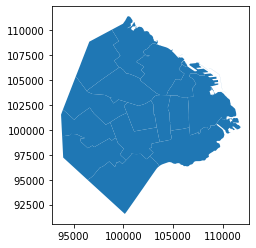

In [50]:
comunas.plot()

In [55]:
dataeah=pd.read_csv("https://github.com/rpasquini/econometrics_and_causality/blob/master/eah2016.csv?raw=true")


In [56]:
dataeah

,id,nhogar,miembro,comuna,dominio,edad,sexo,parentes_2,p5_2,p6_a,p6_b,estado,categori,t13,t14,t18,t28,t29,t29a,t30,sem_hs,t33,t34,t35,t37_cod_2,t37_coda_2,t38,t39,t40,t41_cod_2,t47,t48,t51_bis,i1,i4,i6_3,i10,i11,codioph,ioph_2,...,i3_8x_2,codi3_est,i3_est_2,codi3_otr,i3_otr_2,codnolab,ingnolab_2,coding,ingtot_2,codi_tot,itfb_2,ipcfb_2,e2,e4,e6,e8,e12,e13,e14,edad_30,nivel,aesc,m1,m1_2,m2_anio,m3_anio,tipcob2_2,sn1_1,sn1_7,sn1_2,sn1_3,sn1_4,sn1_5,s8,sn14,sn16,s28,s29,fexp,sexotexto
0,1,1,1,13,resto ciudad,18,mujer,1,6,95,95,ocupado,3,0,0,0,0,0,0,2,8.0,1,1,2,9700,9,0,0,0,57314,0,0,3,1,0,2,0,0,1,1200,...,3000,2,0,2,0,1,3000,1,4380,1,4380,4380,1,1,12,1,No corresponde,0,0,18,6,12,1,1,0,2016,4,2,2,2,1,2,2,2,0,Excelente,2,0,973,mujer
1,2,1,1,1,resto ciudad,18,varon,1,6,95,95,inactivo,0,2,2,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,9000,2,0,2,0,1,9000,1,9000,1,9000,9000,1,3,13,1,No corresponde,0,0,17,6,12,5,5,2016,2016,4,2,2,2,1,2,2,2,0,Excelente,0,0,115,varon
2,3,1,1,6,inquilinatos hoteles inmuebles tomados,18,mujer,1,6,95,95,ocupado,3,0,0,0,0,0,0,2,32.0,1,1,1,9700,9,0,0,0,57314,0,0,3,1,0,2,0,0,1,1650,...,0,1,780,2,0,1,780,1,4830,1,4830,4830,1,1,13,11,No corresponde,0,0,18,6,12,6,6,0,2016,1,2,2,2,2,2,2,2,0,Excelente,2,0,223,mujer
3,4,1,1,14,resto ciudad,18,varon,1,6,95,95,inactivo,0,2,2,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15000,2,0,2,0,9,15000,9,15000,9,15000,15000,1,2,13,1,No corresponde,0,0,18,6,12,3,3,0,2016,4,2,2,2,1,2,2,2,0,Excelente,0,0,421,varon
4,5,1,1,2,resto ciudad,18,varon,1,6,95,95,inactivo,0,2,2,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15000,2,0,2,0,1,15000,1,15000,1,15000,15000,1,3,13,1,No corresponde,0,0,18,6,12,2,2,0,2016,4,2,2,2,1,2,2,2,0,Bueno,0,0,199,varon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14507,5943,1,2,10,resto ciudad,45,mujer,9,3,0,0,ocupado,3,0,0,0,0,0,0,1,0.0,2,0,2,9700,9,0,0,0,57314,0,0,1,1,0,2,0,0,1,6300,...,0,2,0,2,0,2,0,1,6300,9,4900,4900,2,0,0,0,Secundario/ medio común,2,1,45,4,8,5,5,2012,2012,1,2,2,2,2,2,2,2,0,Muy bueno,1,5,242,mujer
14508,5944,1,1,1,resto ciudad,99,mujer,1,4,0,0,inactivo,0,2,2,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5000,2,0,2,0,9,21000,9,21000,9,21000,21000,2,0,0,0,Terciario/ superior no universitario,1,0,99,7,15,3,3,0,1947,2,1,2,2,2,2,2,2,0,Excelente,1,6,112,mujer
14509,5944,1,2,1,resto ciudad,55,mujer,9,2,0,0,ocupado,3,0,0,0,0,0,0,1,140.0,2,0,2,9700,9,0,0,0,55314,0,0,1,1,0,2,0,0,1,10000,...,0,2,0,2,0,2,0,1,10000,9,21000,21000,2,0,0,0,Primario común,2,4,54,2,4,4,5,2011,2011,2,1,2,2,2,2,2,2,0,Regular,1,4,112,mujer
14510,5945,1,1,13,resto ciudad,102,varon,1,4,0,0,inactivo,0,2,2,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,2,0,2,0,9,7500,9,7500,9,7500,7500,2,0,0,0,Secundario/ medio común,1,0,101,5,12,1,1,0,1,4,2,2,2,1,2,2,2,0,Bueno,0,0,185,varon


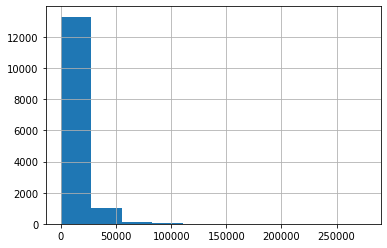

In [63]:
dataeah.ingtot_2.hist()

In [57]:
def mnlogit(lista, data):
  """ 
  Funcion que realiza la regresion Multinomial Logit
  La primera variable de la lista es la dependiente, el resto son las explicativas
  data es la base de datos
  """
  datos=data[lista]
  # el metodo dropna() me permite eliminar las filas que tienen algun valor missing
  datos=datos.dropna()
  Y=datos[lista[0]]
  X=datos[lista[1:]]
  X=sm.add_constant(X)
  modelo=sm.MNLogit(Y,X)
  modeloajustado=modelo.fit()
  print(modeloajustado.summary())
  return modeloajustado

In [61]:
modeloajustado=mnlogit(['comuna', 'ingtot_2', 'edad'], dataeah)

Optimization terminated successfully.
         Current function value: 2.620393
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                 comuna   No. Observations:                14512
Model:                        MNLogit   Df Residuals:                    14470
Method:                           MLE   Df Model:                           28
Date:                Thu, 23 Jul 2020   Pseudo R-squ.:                 0.01219
Time:                        21:28:04   Log-Likelihood:                -38027.
converged:                       True   LL-Null:                       -38496.
Covariance Type:            nonrobust   LLR p-value:                1.638e-179
  comuna=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0518      0.088    -12.010      0.000      -1.223      -0.880
ingtot_2    3.162e-05   3.28e

In [92]:
modeloajustado.predict([1,20000,60])

array([[0.09499062, 0.07188986, 0.08289212, 0.07545277, 0.06886398,
        0.07374537, 0.07111894, 0.06279312, 0.04695586, 0.04613311,
        0.03362737, 0.0639365 , 0.07455247, 0.07169329, 0.06135463]])